In [ ]:
%cd ../src/

In [2]:
%run nets.py
%run simulation.py
%run dataset.py
%run utils.py
%run fit.py

In [342]:
import numpy as np

def get_bins(timesteps, min_bin_length=4):
    bins = {}
    maxlen = np.ceil(timesteps / min_bin_length)
    for i in range(1, int(maxlen + 1)):
        bins[i] = int(np.ceil(timesteps / i))
    bins = np.array(sorted(set(bins.values())))
    return bins

In [343]:
import pandas as pd
import torch
import tqdm

runid = '7ff24a9c'
net = ResNet(1)
net.load_state_dict(
    torch.load(f"../models/{runid}.pt", 
    map_location=torch.device('cpu'))["state_dict"]
)
net.eval()

timesteps = 200
n_agents = 1000
bins = get_bins(timesteps)
n_reps = 1000

selection_values = np.concatenate(
   ([0], np.exp(np.linspace(np.log(0.001), np.log(1), 200 - 1))))

In [346]:
nn_results, fit_results = [], []

for rep in tqdm.trange(n_reps):
    data_dict = collections.defaultdict(list)
    for i, selection in enumerate(selection_values):
        data = wright_fisher(n_agents, timesteps, selection, start=0.5)
        for bin_size in bins:
            binned_data = np.array(apply_binning(data, bin_size, n_agents))
            data_dict[bin_size].append((selection, torch.FloatTensor(binned_data)))
            
            # Perform the FIT test
            fit_data = binned_data[binned_data < 1]
            if len(fit_data) > 3:
                fit = frequency_increment_test(np.arange(1, len(fit_data) + 1), fit_data)
            else:
                fit = {"Tp": None, "Wp": None}
            fit.update({
                "selection": selection,
                "bin": bin_size,
            })
            fit_results.append(fit)
            
    for bin_size, data in data_dict.items():
        selection, data = zip(*data)
        data = torch.stack(data).unsqueeze(1)
        with torch.no_grad():
            probs = torch.sigmoid(net(data)).numpy().squeeze(1)
            preds = probs > 0.5
            for i, pred in enumerate(preds.tolist()):
                nn_results.append({
                    "selection": selection[i],
                    "bin": bin_size,
                    "pred": pred,
                    "prob": probs[i]
                })

100%|██████████| 1000/1000 [1:45:07<00:00,  6.31s/it]


In [545]:
nn_df = pd.DataFrame(nn_results)
fit_df = pd.DataFrame(fit_results)

In [546]:
nn_df['FP'] = (nn_df['selection'] == 0) & (nn_df['pred'] == True)
nn_df['FN'] = (nn_df['selection'] > 0) & (nn_df['pred'] != True)
nn_df['F'] = nn_df["FN"] | nn_df["FP"]
nn_df["y_true"] = (nn_df["selection"] > 0).astype(int)
nn_df.head()

,selection,bin,pred,prob,FP,FN,F,y_true
0,0.000000,4,False,2.997331e-09,False,False,False,0
1,0.001000,4,False,5.542440e-11,False,True,True,1
2,0.001036,4,False,7.880245e-09,False,True,True,1
3,0.001072,4,False,3.712663e-06,False,True,True,1
4,0.001110,4,False,1.048996e-09,False,True,True,1


In [550]:
fit_df['FP'] = ((fit_df['selection'] == 0) & (fit_df['Tp'].isnull() | (fit_df['Tp'] < 0.05)))
fit_df['FN'] = ((fit_df['selection'] > 0) & (fit_df['Tp'].isnull() | (fit_df['Tp'] > 0.05)))
fit_df['F'] = fit_df["FN"] | fit_df["FP"]
fit_df['pred'] = (fit_df['Tp'].notnull()) & (fit_df['Tp'] < 0.05)
fit_df['y_true'] = (fit_df['selection'] > 0).astype(int)
fit_df['normal'] = 1
fit_df.loc[fit_df['Wp'].isnull() | (fit_df['Wp'] < 0.05), 'normal'] = np.nan
fit_df.head()

,T,Tp,W,Wp,selection,bin,FP,FN,F,pred,y_true,normal
0,0.220028,0.846266,0.955543,0.594262,0.0,4,False,False,False,False,0,1.0
1,0.502767,0.649716,0.964001,0.804054,0.0,5,False,False,False,False,0,1.0
2,0.399676,0.709818,0.927516,0.579530,0.0,6,False,False,False,False,0,1.0
3,0.424653,0.688743,0.945452,0.703355,0.0,7,False,False,False,False,0,1.0
4,0.425047,0.685624,0.863838,0.163807,0.0,8,False,False,False,False,0,1.0


In [551]:
import matplotlib.pyplot as plt
import cmocean

plt.style.use("tufte")

def plot_heat(df, ax=None, ylabel=None, title=None, mask=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    if mask is not None:
        df[mask] = np.nan
    
    img = ax.imshow(
        df, aspect="auto", cmap=plt.cm.cividis, vmin=0, vmax=1) # cmocean.cm.haline_r
    
    # correct x-ticks
    ticks = np.exp(np.linspace(np.log(0.001), np.log(1), 4))
    locs = np.where(np.isin(selection_values, ticks))[0]
    ax.set_xticks(locs)
    ax.set_xticklabels([f'{s:.13g}' for s in ticks])
    
    # correct y-ticks
    ax.set_yticks(np.arange(bins.shape[0]))
    ax.set_yticklabels(bins)
    
    # Set labels
    ax.set(xlabel="selection strength", ylabel=ylabel)
    ax.set_title(title, fontsize=18, pad=20)
    return ax, img

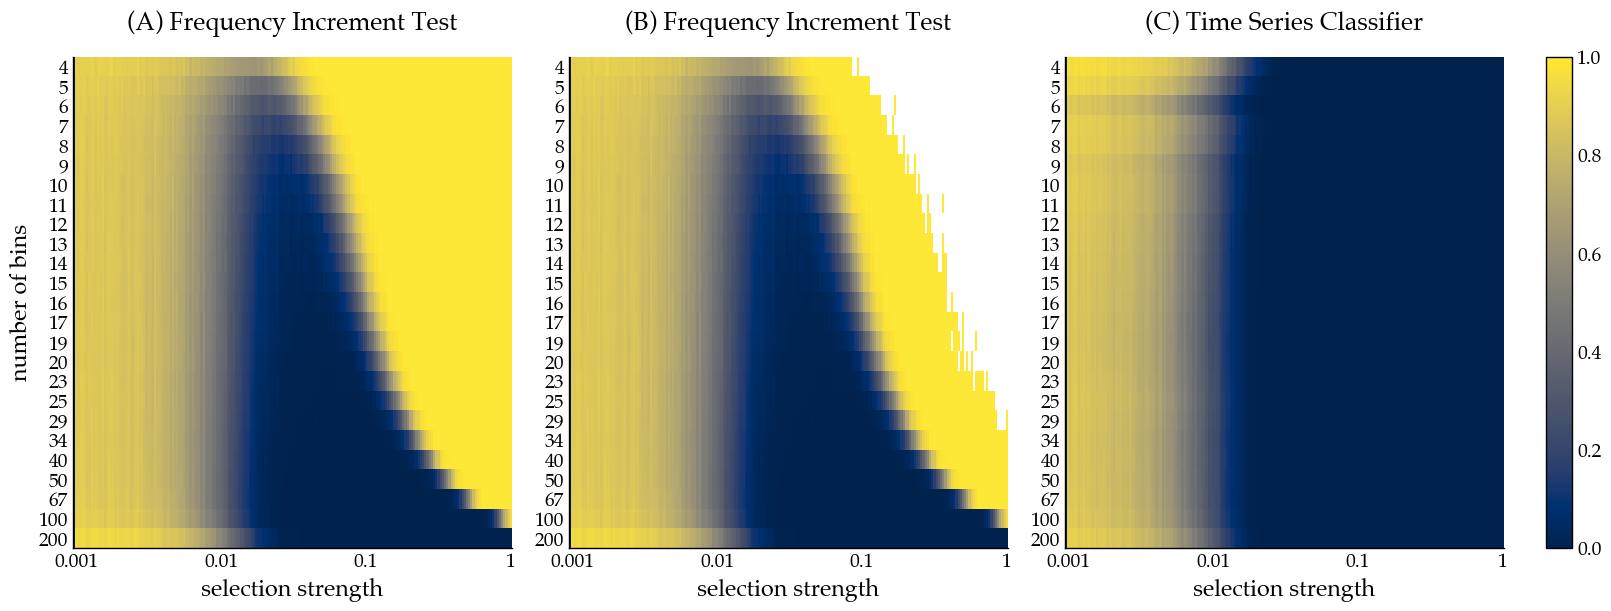

In [552]:
fig, (fit_ax, fit_norm_ax, nn_ax) = plt.subplots(ncols=3, figsize=(16, 6))

F = fit_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=fit_ax, title="(A) Frequency Increment Test", ylabel="number of bins")

F = (fit_df.groupby(["selection", "bin"])["FN"].mean().unstack().T * 
     fit_df.groupby(["selection", "bin"])["normal"].mean().unstack().T)
ax, img = plot_heat(F, ax=fit_norm_ax, title="(B) Frequency Increment Test")

F = nn_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=nn_ax, title="(C) Time Series Classifier")

fig.colorbar(img, ax=(fit_ax, fit_norm_ax, nn_ax), aspect=50)

plt.savefig("../overleaf/paper/plots/selection_over_bin.png", transparent=True, dpi=300)

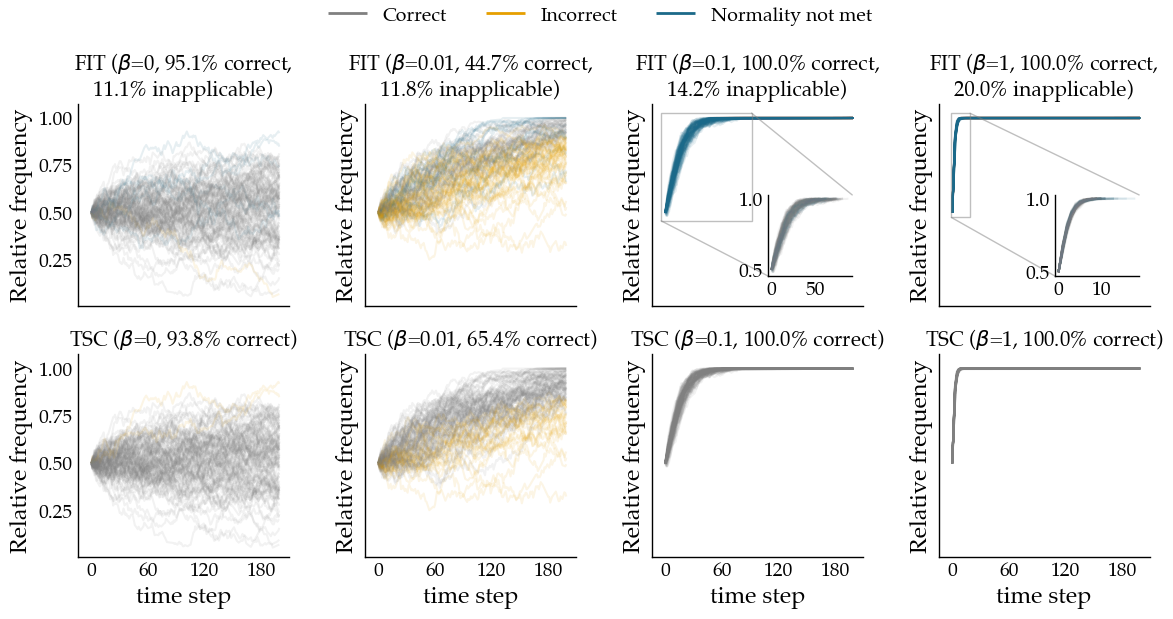

In [581]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, axes = plt.subplots(
    ncols=4, nrows=2, figsize=(12, 6), 
    sharex=True, sharey=True, constrained_layout=False)

axins = (axes[0, 2].inset_axes([0.55, 0.15, 0.4, 0.4]), 
         axes[0, 3].inset_axes([0.55, 0.15, 0.4, 0.4]))
axins[0].patch.set_visible(False)
axins[1].patch.set_visible(False)

for i, selection in enumerate((0, 0.01, 0.1, 1)):
    fit_accuracy, nn_accuracy = 0, 0
    batch, original_batch = [], []
    fit_total = 0
    for rep in range(1000):
        data = wright_fisher(1000, timesteps, selection, start=0.5)
        binned_data = np.array(apply_binning(data, 200, 1000))
        original_batch.append(binned_data)
        batch.append(binned_data)
        # truncate series for absorption
        fit_data = binned_data[(binned_data < 1) & (binned_data > 0)]
        fit = frequency_increment_test(np.arange(1, len(fit_data) + 1), fit_data)
        fit_raw = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
        color = ('C1' if (fit['Wp'] < 0.1) else 
                 'C2' if (fit['Tp'] < 0.05 and selection == 0) else 
                 'C2' if (selection > 0 and fit['Tp'] > 0.05) else
                 'grey')
        
        color_raw = ('C1' if (fit_raw['Wp'] < 0.1) else 
                     'C2' if (fit_raw['Tp'] < 0.05 and selection == 0) else 
                     'C2' if (selection > 0 and fit_raw['Tp'] > 0.05) else
                     'grey')
        
        if color == 'grey':
            fit_accuracy += 1
        if color != "C1":
            fit_total += 1
                    
        if rep <= 100:
            axes[0, i].plot(binned_data, color=color_raw, alpha=0.1)
            if i >= 2:
                axins[i - 2].plot(fit_data, color=color, alpha=0.1)
    if i >= 2:
        axes[0, i].indicate_inset_zoom(axins[i - 2])            

    with torch.no_grad():
        prob = torch.sigmoid(
            net(torch.FloatTensor(batch).unsqueeze(1))
        ).numpy().squeeze(1)
        pred = prob > 0.5
        for j, sample in enumerate(original_batch):
            color = ('C2' if (pred[j] and selection == 0) else 
                     'C2' if (selection > 0 and not pred[j]) else
                     'grey')

            if color == "grey":
                nn_accuracy += 1

            if j <= 100:
                axes[1, i].plot(sample, color=color, alpha=0.1)

    axes[0, i].set_ylabel("Relative frequency")
    axes[0, i].spines['top'].set_visible(False)
    axes[0, i].spines['right'].set_visible(False)
    axes[0, i].set_title(f'FIT ($\\beta$={selection}, {fit_accuracy/fit_total:.1%} correct,\n{1 - (fit_total/1000):.1%} inapplicable)', fontsize=15)
    axes[0, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    axes[1, i].set_xlabel("time step")
    axes[1, i].set_ylabel("Relative frequency")
    axes[1, i].spines['top'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)
    axes[1, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[1, i].set_title(f'TSC ($\\beta$={selection}, {nn_accuracy/1000:.1%} correct)', fontsize=15)
    
custom_lines = [Line2D([0], [0], color="grey", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C1", lw=2)]
fig.legend(custom_lines, ['Correct', 'Incorrect', 'Normality not met'], 
          loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05), frameon=False)
plt.tight_layout()
plt.savefig("../plots/fixed-bin-varying-selection.png", 
            transparent=True, dpi=300, bbox_inches='tight')

In [142]:
def tsplot(
    y,
    x=None,
    n=50,
    percentile_min=1,
    percentile_max=99,
    color="C0",
    location="mean",
    line_color="k",
    axis=0,
    ax=None,
    label=None,
    **kwargs,
):
    if ax is None:
        fig, ax = plt.subplots()
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.nanpercentile(
        y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=axis
    )
    perc2 = np.nanpercentile(
        y, np.linspace(50, percentile_max, num=n + 1)[1:], axis=axis
    )

    if x is None:
        x = np.arange(y.shape[1])

    if "alpha" in kwargs:
        alpha = kwargs.pop("alpha")
    else:
        alpha = 1 / n
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        ax.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)

    if location == "mean":
        ax.plot(x, np.nanmean(y, axis=axis), '-o', color=line_color, label=label)
    elif location == "median":
        ax.plot(x, np.nanmedian(y, axis=axis), color=line_color, label=label)
    else:
        raise ValueError(f"Location `{location}` is not supported.")

    return ax

In [577]:
subset = nn_df[nn_df["selection"] == 0]
NN_FP = np.zeros((len(bins), n_reps))
for i, binning in tqdm.tqdm(enumerate(bins)):
    bin_df = subset.loc[subset["bin"] == binning, "FP"]
    for j in range(n_reps):
        NN_FP[i,j] = bin_df.sample(500, replace=True).mean()
        
subset = fit_df[(fit_df["selection"] == 0) & (fit_df['Wp'] > 0.1)].copy()
subset["fp_"] = (subset['Tp'] < 0.05)
FIT_FP = np.zeros((len(bins), n_reps))
for i, binning in tqdm.tqdm(enumerate(bins)):
    bin_df = subset.loc[subset["bin"] == binning, "fp_"]
    for j in range(n_reps):
        FIT_FP[i,j] = bin_df.sample(500, replace=True).mean()

25it [00:05,  4.77it/s]
25it [00:05,  4.78it/s]


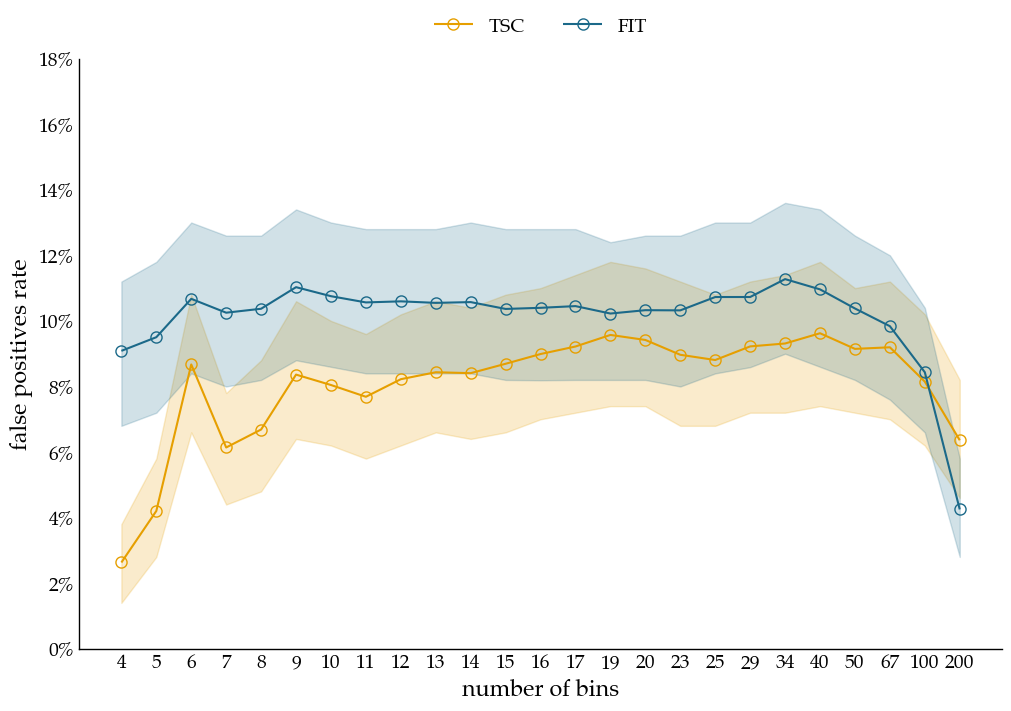

In [555]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter

fig, ax = plt.subplots()

tsplot(NN_FP.T, n=1, ax=ax, label="TSC", color="C2", line_color="C2", alpha=0.2, 
       percentile_min=5, percentile_max=95)
tsplot(FIT_FP.T, n=1, ax=ax, label="FIT", color="C1", line_color="C1", alpha=0.2,
       percentile_min=5, percentile_max=95)
ax.set(xlabel="number of bins", ylabel="false positives rate", ylim=(0, 0.18))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_xticks(list(range(len(bins))))
ax.set_xticklabels(bins)
ax.legend(frameon=False, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1.1))
plt.savefig("../overleaf/paper/plots/fp-rate.png", transparent=True, dpi=300)